In [1]:
# Notebook Imports
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import string
from collections import defaultdict
from sklearn.metrics import r2_score
import statsmodels.api as sm
%matplotlib inline

conn = psycopg2.connect(dbname="illinois_gambling")

def query(query):
    return pd.read_sql(query, conn)

## Introduction

Video gambling was legalized by the state of Illinois in 2009, with the first machines activated in September of 2012. Since then the number of towns that have installed video gambling machines has increased every year. 

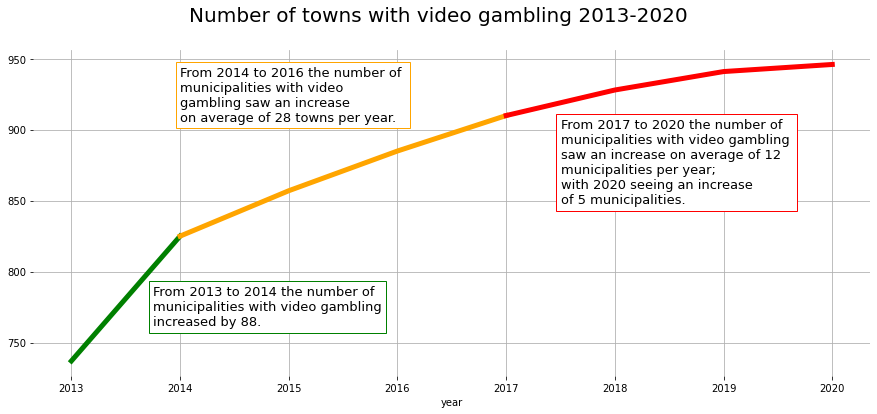

In [2]:
q = '''SELECT DISTINCT CAST(date_part('year', video_gambling.date) AS INT) as year, 
              count(DISTINCT municipality.name) as num_of_towns
       FROM municipality
       INNER JOIN video_gambling
       ON municipality.name = video_gambling.municipality
       GROUP BY date_part('year', video_gambling.date);'''

query_results = query(q).set_index('year')
fig, ax = plt.subplots()
query_results.loc[:2014].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='green')
query_results.loc[2014:2017].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='orange')
query_results.loc[2017:].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='red')
# axes[0].set_yticks(query_results.num_of_towns)
fig.suptitle('Number of towns with video gambling 2013-2020', fontsize=20)
ax.grid()

ax.set_frame_on(False)

first_annotation = ax.text(2013.75, 762, 
f'''From 2013 to 2014 the number of\nmunicipalities \
with video gambling\nincreased by\
 {int(query_results.loc[[2013,2014]].num_of_towns.diff().iloc[1])}.''', dict(size=13))
first_annotation.set_bbox(dict(facecolor='white', edgecolor='green'))

second_annotation = ax.text(2014, 906, f'''\
From 2014 to 2016 the number of 
municipalities with video 
gambling saw an increase\non average of \
{int(round(query_results.loc[2014:2017].num_of_towns.diff().mean()))} \
towns per year.''', dict(size=13))
second_annotation.set_bbox(dict(facecolor='white', edgecolor='orange'))

third_annotation = ax.text(2017.5, 848, f'''\
From 2017 to 2020 the number of
municipalities with video gambling 
saw an increase on average of \
{int(round(query_results.loc[2017:].num_of_towns.diff().mean()))} 
municipalities per year; 
with 2020 seeing an increase 
of {int(round(query_results.loc[2017:].num_of_towns.diff().loc[2020]))} municipalities.''', dict(size=13))
third_annotation.set_bbox(dict(facecolor='white', edgecolor='red'))


We can see a notable decline in growth for Illinois' video gambling industry for the year of 2020. 

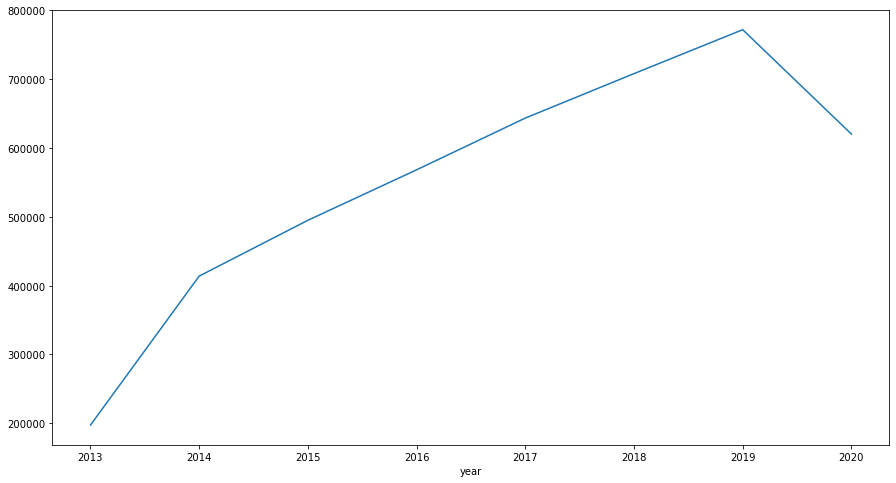

In [4]:
q = """SELECT DISTINCT CAST(date_part('year', video_gambling.date) AS INT) as year, 
                SUM(video_gambling.terminal_count) as terminal_count,
                SUM(video_gambling.amount_played) as amount_played,
                SUM(video_gambling.state_share) as state_share,
                SUM(video_gambling.municipality_share) as local_share
                FROM video_gambling
                GROUP BY date_part('year', video_gambling.date);"""

query(q).set_index('year').terminal_count.plot(figsize=(15,8));

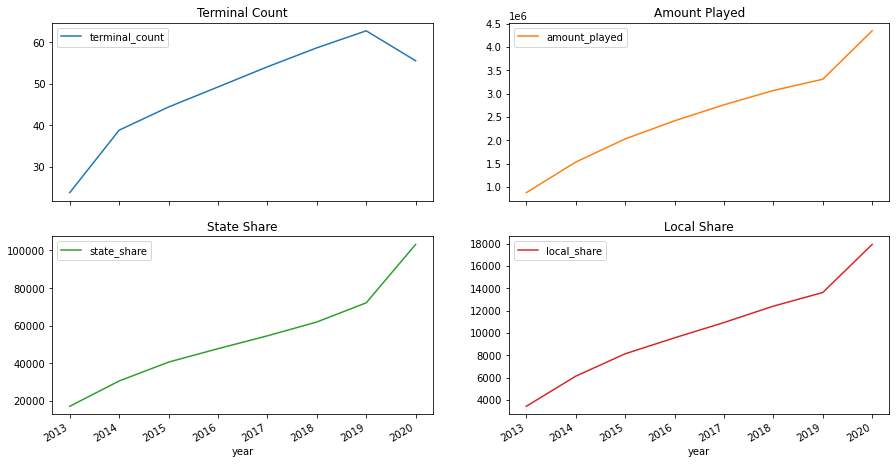

In [4]:
q = '''SELECT year,
              municipality,
              AVG(terminal_count) as terminal_count,
              AVG(amount_played) as amount_played,
              AVG(state_share) as state_share,
              AVG(local_share) as local_share FROM (
                SELECT DISTINCT CAST(date_part('year', video_gambling.date) AS INT) as year, 
                SUM(video_gambling.terminal_count) as terminal_count,
                SUM(video_gambling.amount_played) as amount_played,
                SUM(video_gambling.state_share) as state_share,
                SUM(video_gambling.municipality_share) as local_share,
                video_gambling.municipality
                FROM video_gambling
                GROUP BY date_part('year', video_gambling.date), date_part('month', video_gambling.date), video_gambling.municipality) subquery
              GROUP BY year, municipality;'''
query_results = query(q)
axes = query_results.groupby('year').mean().plot(subplots=True, layout=(2,2), figsize=(15,8))

for row in range(len(axes)):
    for column in range(len(axes[row])):
        axes[row][column].set_title(axes[row][column].get_legend_handles_labels()[1][0].replace('_', ' ').title())

In [5]:
query_results.set_index('year').loc[2020].sort_values('terminal_count', ascending=False).head(10)

,municipality,terminal_count,amount_played,state_share,local_share
year,,,,,
2020,Springfield,1041.000000,8.945283e+07,2.114894e+06,367042.023636
2020,Rockford,751.636364,8.929716e+07,2.140180e+06,371384.655455
2020,Decatur,701.090909,8.907173e+07,2.204057e+06,382324.751818
2020,Joliet,615.363636,4.415895e+07,1.045264e+06,181461.024545
2020,Loves Park,530.727273,5.554791e+07,1.329000e+06,230526.067273
2020,Lake County,483.181818,3.614601e+07,8.704939e+05,151038.300000
2020,Peoria,468.400000,3.612465e+07,8.320130e+05,144491.005000
2020,Waukegan,459.272727,5.915709e+07,1.449211e+06,251359.723636
2020,Berwyn,438.818182,3.417288e+07,8.451855e+05,146656.995455


In [230]:
query_results

,terminal_count,amount_played,state_share,local_share
year,,,,
2013,122.080054,4.793005e+06,93495.091547,18697.404233
2014,226.865455,9.178684e+06,183437.008642,36687.323624
2015,261.312719,1.225567e+07,245650.282322,49130.161330
2016,291.463277,1.461970e+07,289150.200079,57829.938249
2017,322.610989,1.676802e+07,332064.160418,66412.720582
2018,349.070043,1.859820e+07,376217.967866,75243.474709
2019,375.375133,2.008037e+07,438449.198247,82716.016397
2020,208.350951,1.039396e+07,245635.627526,42997.097283


In [274]:
query("""
        SELECT v.municipality,
        SUM(v.terminal_count) as terminal_count,
        date_part('month', v.date) as month,
        date_part('year', v.date) as year
        FROM video_gambling v
        WHERE date_part('year', v.date) = 2020
        GROUP BY date_part('year', v.date), date_part('month', v.date), v.municipality
        ORDER BY terminal_count DESC;""")\
.drop_duplicates(subset=['municipality'])

,municipality,terminal_count,month,year
0,Springfield,683.0,3.0,2020.0
6,Rockford,492.0,9.0,2020.0
11,Decatur,460.0,3.0,2020.0
18,Joliet,409.0,8.0,2020.0
24,Loves Park,358.0,9.0,2020.0
...,...,...,...,...
6071,Grantfork,2.0,8.0,2020.0
6075,Camp Point,2.0,7.0,2020.0
6078,Arenzville,2.0,9.0,2020.0
6083,Steward,2.0,3.0,2020.0


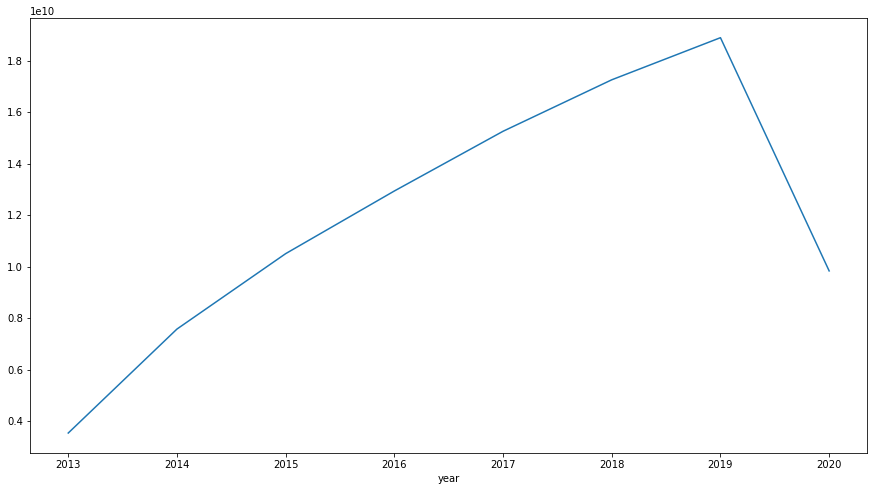

In [199]:
q = '''SELECT DISTINCT CAST(date_part('year', video_gambling.date) AS INT) as year, 
              sum(video_gambling.amount_played) as amount_played
       FROM municipality
       INNER JOIN video_gambling
       ON municipality.name = video_gambling.municipality
       GROUP BY date_part('year', video_gambling.date);'''
query_results = query(q).set_index('year')
fig, ax = plt.subplots()
query_results.amount_played.plot(ax = ax, figsize=(15,8))

## Outline

- Video gambling growth
    - ~~Increase of towns~~
    - Increase of gambling devices
    - Increase of amount played
    - Change in revenue for state and local governments
    - Amount returns to owner
    
- Casino growth
    - Increase in casinos
    - Increase in adjusted gross receipt
    - Increase in local and state shares
    
- Breakdown of tax rates
    - Visualization of the difference in the distribution between the vg and casino tax rates
    
- Analysis of the correlation between amount played and AGR.
    
- Analysis of casino loss 
    - Description of the data that has been collected
    - Description of how municipalities were clustered according to the nearest casino
    - Analysis of the statistical likelyhood of having a tax rate > 30%
        - Check the year frequency within the population of tax rates that fell above 30%
    - Modeling the data with MLM
        - Baseline: AGR ~ amount_played_centered
        - Bring in industry variables
        - Bring in demographic variables

In [2]:




q = '''SELECT DISTINCT municipality
        FROM casino;'''

towns_with_casinos = query(q)

q = '''SELECT DISTINCT town.name
        FROM municipality town
        LEFT JOIN casino ON casino.municipality = town.name
        WHERE casino.municipality IS NULL'''
towns_without_casinos = query(q)

q = '''SELECT * from demographics_lookup'''

lookup = query(q)

demographic_variables = ('demo.' + lookup['variable']).to_list()

q = f'''SELECT {", ".join(demographic_variables)},
              video.terminal_count,
              video.date,
              video.state_share as video_state_share,
              video.municipality_share as video_local_share,
              video.amount_played,
              town.name,
              town.nearest_casino,
              casino.adjusted_gross_receipt,
              casino.state_share as casino_state_share,
              casino.local_share as casino_local_share
      FROM demographics demo
      JOIN municipality town
          ON demo.municipality = town.name
          AND demo.geo_id = town.geo_id
     JOIN casino
          ON casino.address = town.nearest_casino
     JOIN video_gambling video
          ON video.municipality = town.name
     WHERE date_part('year', video.date) = demo.year
     AND casino.date = video.date
     ORDER BY date;'''

df = query(q)

In [21]:
variable_map = lookup.drop('index', axis = 1).set_index('variable').to_dict('index')

def variable_rename(column):
    translator=str.maketrans('','',string.punctuation)
    if column  in variable_map:
        return variable_map[column]['description'].lower().strip().translate(translator).replace(' ', '_')
    else:
        return column

df.columns = [variable_rename(column) for column in df.columns]

In [22]:
df.columns[:3]

Index(['total_agriculture_forestry_fishing_and_hunting_and_mining',
       'total_construction', 'total_manufacturing'],
      dtype='object')

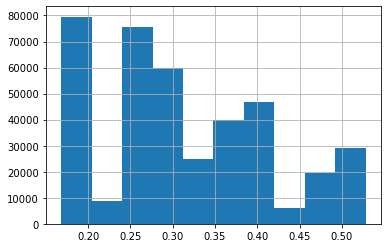

In [19]:
df.tax_rate.hist()

In [58]:
temp = df.groupby([pd.Grouper(freq = 'Y'), 'name'])[['casino_state_share', 'casino_local_share', 
                                                     'video_state_share', 'video_local_share']].sum().reset_index()
temp.head()

,date,name,casino_state_share,casino_local_share,video_state_share,video_local_share
0,2013-12-31,Abingdon,89553252.0,23195190.0,90898.57,18179.72
1,2013-12-31,Addison,337692885.0,42578642.0,90480.28,18095.99
2,2013-12-31,Albers,28197278.0,6646309.0,7213.25,1442.64
3,2013-12-31,Aledo,15984958.0,4153470.0,18344.04,3668.82
4,2013-12-31,Algonquin,103434784.0,15539966.0,50171.83,10034.33


In [81]:
public_share = pd.DataFrame(columns=['name','casino_state', 'casino_local',
                                    'video_state', 'video_local'])
for name in towns_with_casinos.municipality.unique():
    
    _ = temp[temp.name==name].loc['2012':]
    c_state = _.casino_state_share.diff()[1:].mean()
    c_local = _.casino_local_share.diff()[1:].mean()
    v_state = _.video_state_share.diff()[1:].mean()
    v_local = _.video_local_share.diff()[1:].mean()
    public_share = public_share.append({'name':name,'casino_state': c_state, 'casino_local': c_local,
                                       'video_state': v_state, 'video_local': v_local}, ignore_index=True)

In [82]:
public_share

,name,casino_state,casino_local,video_state,video_local
0,Alton,1.861547e+07,9.339162e+06,259107.688000,51820.622000
1,Elgin,3.584831e+07,1.147767e+07,259510.067500,51902.032500
2,Des Plaines,NaN,NaN,NaN,NaN
3,East Peoria,-4.752198e+06,1.488905e+06,83278.562500,16655.615000
4,Rock Island,-1.207166e+07,-2.843272e+06,85666.840000,17133.373333
5,East St. Louis,NaN,NaN,NaN,NaN
6,Aurora,2.013034e+08,4.823823e+07,396047.744000,79209.444000
7,Metropolis,5.698115e+07,1.532606e+07,308548.693333,61709.666667
8,Joliet,6.299680e+07,1.882273e+07,863409.570000,172681.410000


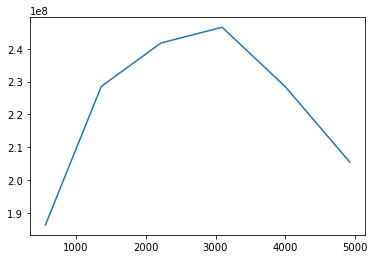

In [80]:
temp[temp.name=='Rock Island'].casino_state_share.plot()

In [24]:
casino_revenue = defaultdict(lambda: defaultdict(dict))
for idx in df.index:
    date = df.date[idx]
    casino = df.nearest_casino[idx]
    year = date.year
    month = date.month
    revenue = df.adjusted_gross_receipt[idx]
    casino_revenue[casino][year][month] = revenue

In [25]:
for casino in casino_revenue:
    for year in casino_revenue[casino]:
        total = sum(list(casino_revenue[casino][year].values()))
        casino_revenue[casino][year]['total'] = total

In [26]:
df.set_index('date', inplace = True)
nearest_casino_groups = df.groupby(['nearest_casino', pd.Grouper(freq='M')]).sum().reset_index()

In [27]:
agr = []
for idx in nearest_casino_groups.index:
    casino = nearest_casino_groups.nearest_casino[idx]
    date = nearest_casino_groups.date[idx]
    year = date.year
    month = date.month
    agr.append(casino_revenue[casino][year][month])

In [28]:
nearest_casino_groups['adjusted_gross_receipt'] = agr

In [11]:
casinos = nearest_casino_groups.nearest_casino.unique()

In [12]:
casino_tables = {}
for casino in casinos:
    casino_tables[casino] = nearest_casino_groups[nearest_casino_groups\
                                                   .nearest_casino == casino]

In [13]:
def subplot_map(idx, columns):
    return (idx//columns, idx%columns)

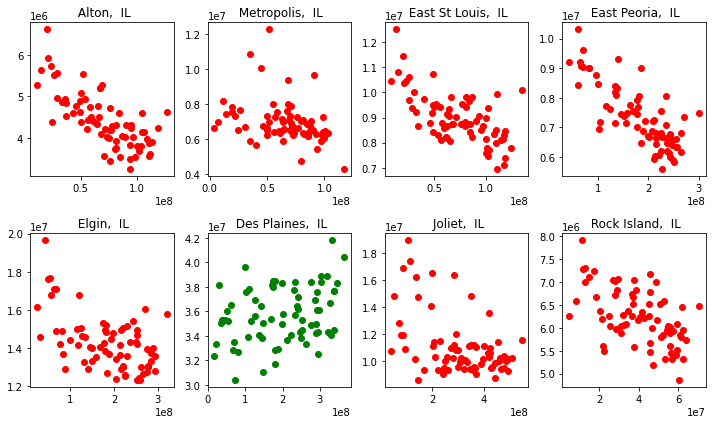

In [14]:
shape = (2,4)
fig, axes = plt.subplots(*shape, figsize=(10,6))

for idx in range(len(casinos)):
    row, column = subplot_map(idx, shape[1])
    casino  = casinos[idx]
    dataframe = casino_tables[casino]
    x = dataframe.amount_played
    y = dataframe.adjusted_gross_receipt
    hline = dataframe.total_population_estimatetotal.mean()
    axes[row, column].scatter(x,y, color='green' if list(y)[-1] > list(y)[0] else 'red')
#     axes[row,column].hlines(hline, x.min(), x.max())
    title = casino.split(',')
    title = title[1] + ', ' + title[2][:3]
    axes[row, column].set_title(title)
fig.tight_layout()

In [15]:
model = sm.OLS(nearest_casino_groups.adjusted_gross_receipt, nearest_casino_groups.amount_played).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     adjusted_gross_receipt   R-squared (uncentered):                   0.528
Model:                                OLS   Adj. R-squared (uncentered):              0.527
Method:                     Least Squares   F-statistic:                              642.7
Date:                    Wed, 16 Dec 2020   Prob (F-statistic):                    1.04e-95
Time:                            18:51:49   Log-Likelihood:                         -10111.
No. Observations:                     575   AIC:                                  2.022e+04
Df Residuals:                         574   BIC:                                  2.023e+04
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
amount_played     0.0621      0.002     25.353      0.000       0.057       0.067
==============================================================================
Omnibus:                       64.255   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.289
Skew:                           0.741   Prob(JB):                     6.14e-23
Kurtosis:                       4.440   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
nearest_casino_groups['amount_played_centered'] = nearest_casino_groups\
                                                .groupby("nearest_casino")["amount_played"]\
                                                .transform(lambda x: (x - x.mean())/x.std())

nearest_casino_groups['population_centered'] = nearest_casino_groups\
                                            .groupby('nearest_casino')['total_population_estimatetotal']\
                                            .transform(lambda x: (x-x.mean())/x.std())

                                                

model = sm.MixedLM.from_formula('adjusted_gross_receipt ~ amount_played_centered', 
                        groups='nearest_casino',
                        data=nearest_casino_groups)

results = model.fit()
results.summary()                                                

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                     MixedLM         Dependent Variable:         adjusted_gross_receipt
No. Observations:          575             Method:                     REML                  
No. Groups:                8               Scale:                      1879783788722.2612    
Min. group size:           71              Log-Likelihood:             -8945.4585            
Max. group size:           72              Converged:                  Yes                   
Mean group size:           71.9                                                              
---------------------------------------------------------------------------------------------
                              Coef.          Std.Err.     z    P>|z|    [0.025      0.975]   
---------------------------------------------------------------------------------------------
Intercept                     11894909.487  3573153.922  3.329 0.001 4891656.487 18898162.486
amount_played_centered         -480584.225    57578.775 -8.347 0.000 -593436.550  -367731.900
nearest_casino Var     102113277549692.781 40021884.274                                      
=============================================================================================

"""

In [18]:
model = sm.OLS(nearest_casino_groups.adjusted_gross_receipt, nearest_casino_groups.amount_played_centered).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     adjusted_gross_receipt   R-squared (uncentered):                   0.001
Model:                                OLS   Adj. R-squared (uncentered):             -0.001
Method:                     Least Squares   F-statistic:                             0.5609
Date:                    Wed, 16 Dec 2020   Prob (F-statistic):                       0.454
Time:                            18:53:39   Log-Likelihood:                         -10327.
No. Observations:                     575   AIC:                                  2.066e+04
Df Residuals:                         574   BIC:                                  2.066e+04
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
amount_played_centered -4.806e+05   6.42e+05     -0.749      0.454   -1.74e+06     7.8e+05
==============================================================================
Omnibus:                      198.054   Durbin-Watson:                   0.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              457.130
Skew:                           1.879   Prob(JB):                    5.44e-100
Kurtosis:                       5.227   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
casino_dataframe.reset_index(inplace=True)

In [44]:
industry_variables = ['total_agriculture_forestry_fishing_and_hunting_and_mining',
       'total_construction', 'total_manufacturing', 'total_wholesale_trade',
       'total_retail_trade',
       'total_transportation_and_warehousing_and_utilities',
       'total_information',
       'total_finance_and_insurance_and_real_estate_and_rental_and_leasing',
       'total_professional_scientific_and_management_and_administrative_and_waste_management_services',
       'total_educational_services_and_health_care_and_social_assistance',
       'total_arts_entertainment_and_recreation_and_accommodation_and_food_services',
       'total_other_services_except_public_administration',
       'total_public_administration',
       'total_management_business_science_and_arts_occupations',
       'total_service_occupations', 'total_sales_and_office_occupations',
       'total_natural_resources_construction_and_maintenance_occupations',
       'total_production_transportation_and_material_moving_occupations']

In [46]:
table = casino_dataframe[industry_variables].div(casino_dataframe.total_population_estimatetotal, axis=0)
largest_industry = []
for idx in table.index:
    industry = table.loc[idx][industry_variables].sort_values(ascending=False).index[0]
    largest_industry.append(industry)

**TO DO**

Take the dataframe above and see if you can cluster these observations according to industry representation. 

In [252]:
casino_dataframe['amount_played_centered'] = casino_dataframe\
                                                .groupby("nearest_casino")["amount_played"]\
                                                .transform(lambda x: (x - x.mean())/x.std())

casino_dataframe['population_centered'] = casino_dataframe\
                                            .groupby('nearest_casino')['total_population_estimatetotal']\
                                            .transform(lambda x: (x-x.mean())/x.std())
                                                

model = sm.MixedLM.from_formula('adjusted_gross_receipt ~ amount_played_centered',
                        re_formula='1',
                        groups='nearest_casino',
                        data=casino_dataframe)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                     MixedLM         Dependent Variable:         adjusted_gross_receipt
No. Observations:          575             Method:                     REML                  
No. Groups:                8               Scale:                      1911020226108.7695    
Min. group size:           71              Log-Likelihood:             -8950.1214            
Max. group size:           72              Converged:                  Yes                   
Mean group size:           71.9                                                              
---------------------------------------------------------------------------------------------
                              Coef.          Std.Err.     z    P>|z|    [0.025      0.975]   
---------------------------------------------------------------------------------------------
Intercept                     11888781.657  3572607.040  3.328 0.001 4886600.527 18890962.787
amount_played_centered         -449165.228    58055.198 -7.737 0.000 -562951.325  -335379.130
nearest_casino Var     102081579834167.859 39684636.969                                      
=============================================================================================

"""

In [253]:
def magnitude(coefficient):
    return np.sqrt(2*coefficient)

In [266]:
magnitude(results.cov_re.iloc[0].values[0])

14288567.4463305

# Can I get the autoregressive model working? Can I somehow factor for time? 

In [236]:
casino_dataframe_autoregressive = casino_dataframe[casino_dataframe.date >= '2014']
casino_dataframe_autoregressive.set_index('date', inplace=True)

In [238]:
type(casino_dataframe_autoregressive.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [247]:
# model_autoregressive = sm.GEE().from_formula(
#     formula = "adjusted_gross_receipt ~ amount_played_centered",
#     groups="nearest_casino",
#     cov_struct=sm.cov_struct.Autoregressive(),
#     data=casino_dataframe_autoregressive
#     ).fit()

X = casino_dataframe_autoregressive.amount_played_centered
y = casino_dataframe_autoregressive.adjusted_gross_receipt
X = sm.add_constant(X)
model_autoregressive = sm.GEE(y,X,
                            groups=casino_dataframe_autoregressive.nearest_casino, times=casino_dataframe_autoregressive.index,
                            cov_struct=sm.cov_struct.Autoregressive())

model_autoregressive = model_autoregressive.fit()
model_autoregressive.summary()

ValueError: Autoregressive: unable to find right bracket

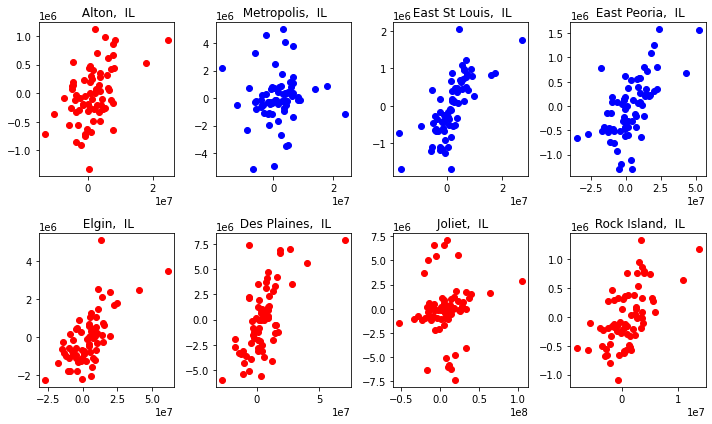

In [46]:
shape = (2,4)
fig, axes = plt.subplots(*shape, figsize=(10,6))

for idx in range(len(casinos)):
    row, column = subplot_map(idx, shape[1])
    casino  = casinos[idx]
    dataframe = differences[differences.casino == casino]
    x = dataframe.amount_played
    y = dataframe.adjusted_gross_receipt
    axes[row, column].scatter(x,y, color='red' if list(y)[-1] > list(y)[0] else 'blue')
    title = casino.split(',')
    title = title[1] + ', ' + title[2][:3]
    axes[row, column].set_title(title)
fig.tight_layout()

In [39]:
vc = {'amount_played_centered': '0 + amount_played_centered'}
model = sm.MixedLM.from_formula('adjusted_gross_receipt ~ amount_played_centered', 
                        vc_formula=vc,
                        groups='casino',
                        data=differences)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
===========================================================================================
Model:                     MixedLM        Dependent Variable:        adjusted_gross_receipt
No. Observations:          567            Method:                    REML                  
No. Groups:                8              Scale:                     2430229783450.1279    
Min. group size:           70             Log-Likelihood:            -8873.3157            
Max. group size:           71             Converged:                 Yes                   
Mean group size:           70.9                                                            
-------------------------------------------------------------------------------------------
                                Coef.        Std.Err.    z    P>|z|    [0.025      0.975]  
-------------------------------------------------------------------------------------------
Intercept                        -19135.295  65468.462 -0.292 0.770 -147451.123  109180.534
amount_played_centered           596838.670 227286.787  2.626 0.009  151364.752 1042312.587
amount_played_centered Var 378493874023.188 142606.711                                     
===========================================================================================

"""

In [41]:
model_autoregressive = sm.GEE.from_formula(
    formula = "adjusted_gross_receipt ~ amount_played_centered",
    groups="casino",
    cov_struct=sm.cov_struct.Autoregressive(), 
    data=differences
    ).fit()

model_autoregressive.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                GEE Regression Results                               
=====================================================================================
Dep. Variable:        adjusted_gross_receipt   No. Observations:                  567
Model:                                   GEE   No. clusters:                        8
Method:                          Generalized   Min. cluster size:                  70
                        Estimating Equations   Max. cluster size:                  71
Family:                             Gaussian   Mean cluster size:                70.9
Dependence structure:         Autoregressive   Num. iterations:                     2
Date:                       Sat, 31 Oct 2020   Scale:               2758338938291.368
Covariance type:                      robust   Time:                         17:20:25
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.914e+04   1.67e+04     -1.147      0.252   -5.18e+04    1.36e+04
amount_played_centered  5.969e+05   2.13e+05      2.803      0.005     1.8e+05    1.01e+06
==============================================================================
Skew:                          0.3777   Kurtosis:                       6.2037
Centered skew:                 0.3534   Centered kurtosis:              6.1352
==============================================================================
"""

In [ ]:
172,485,344,229
596,900

In [183]:
algo = OLS(differences.adjusted_gross_receipt, differences.amount_played)

In [184]:
model = algo.fit()

In [185]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     adjusted_gross_receipt   R-squared (uncentered):                   0.146
Model:                                OLS   Adj. R-squared (uncentered):              0.145
Method:                     Least Squares   F-statistic:                              97.04
Date:                    Mon, 26 Oct 2020   Prob (F-statistic):                    3.08e-21
Time:                            22:40:31   Log-Likelihood:                         -8907.7
No. Observations:                     567   AIC:                                  1.782e+04
Df Residuals:                         566   BIC:                                  1.782e+04
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
amount_played     0.0530      0.005      9.851      0.000       0.042       0.064
==============================================================================
Omnibus:                       86.597   Durbin-Watson:                   3.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.645
Skew:                          -0.051   Prob(JB):                    7.17e-229
Kurtosis:                       9.668   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

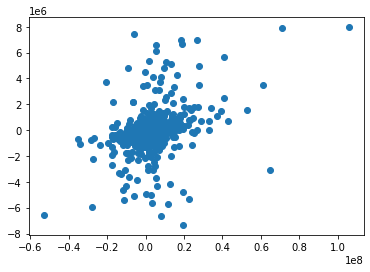

In [186]:
plt.scatter(differences.amount_played, differences.adjusted_gross_receipt)

In [187]:
from sklearn.linear_model import LinearRegression

In [188]:
model = LinearRegression()
model.fit(differences.amount_played.to_numpy().reshape(-1,1), differences.adjusted_gross_receipt.to_numpy().reshape(-1,1))

LinearRegression()

In [189]:
preds = model.predict(differences.amount_played.to_numpy().reshape(-1,1))

In [190]:
from sklearn.metrics import r2_score

In [191]:
r2_score(differences.adjusted_gross_receipt.to_numpy().reshape(-1,1), preds)

0.15584202108358425

In [208]:
monthly_terminal_count = df[['name', 'terminal_count', 'total_population_estimatetotal']].groupby(['name', pd.Grouper(freq='MS')]).sum().reset_index()
monthly_terminal_count[monthly_terminal_count.terminal_count > 100].name.value_counts()

Joliet         72
Rockford       71
Springfield    70
Bloomington    69
Kankakee       67
               ..
Oswego          4
Marion          4
East Moline     3
Sandwich        2
Metropolis      1
Name: name, Length: 91, dtype: int64

In [202]:
monthly_terminal_count[monthly_terminal_count.terminal_count < 50]

terminal_count
name     date                      
Abingdon 2013-01-01            10.0
         2013-02-01            14.0
         2013-03-01            14.0
         2013-04-01            14.0
         2013-05-01            17.0
...                             ...
Zion     2018-08-01            35.0
         2018-09-01            35.0
         2018-10-01            35.0
         2018-11-01            35.0
         2018-12-01            35.0

[47629 rows x 1 columns]

In [193]:
df[['name', 'terminal_count']].groupby(['name', pd.Grouper(freq='MS')]).sum()

terminal_count
name     date                      
Abingdon 2013-01-01            10.0
         2013-02-01            14.0
         2013-03-01            14.0
         2013-04-01            14.0
         2013-05-01            17.0
...                             ...
Zion     2018-08-01            35.0
         2018-09-01            35.0
         2018-10-01            35.0
         2018-11-01            35.0
         2018-12-01            35.0

[57353 rows x 1 columns]

In [194]:
df.columns

Index(['total_agriculture_forestry_fishing_and_hunting_and_mining',
       'total_construction', 'total_manufacturing', 'total_wholesale_trade',
       'total_retail_trade',
       'total_transportation_and_warehousing_and_utilities',
       'total_information',
       'total_finance_and_insurance_and_real_estate_and_rental_and_leasing',
       'total_professional_scientific_and_management_and_administrative_and_waste_management_services',
       'total_educational_services_and_health_care_and_social_assistance',
       'total_arts_entertainment_and_recreation_and_accommodation_and_food_services',
       'total_other_services_except_public_administration',
       'total_public_administration',
       'total_management_business_science_and_arts_occupations',
       'total_service_occupations', 'total_sales_and_office_occupations',
       'total_natural_resources_construction_and_maintenance_occupations',
       'total_production_transportation_and_material_moving_occupations',
       'p